In [8]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle

import numpy as np
#from ler.rates import LeR
import json
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import LambdaCDM
cosmoLambdaCDM = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

from astropy.cosmology import Planck18

from scipy.integrate import quad
from scipy.stats import gengamma, rayleigh

In [9]:
from ler.lens_galaxy_population import LensGalaxyPopulation

lens = LensGalaxyPopulation(z_max=40, cosmology=cosmoLambdaCDM,) 

## SIS

In [10]:
@jit
def cross_section(sigma, zl, zs):
    Ds = cosmo.angular_diameter_distance(zs)
    Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / (Ds)
    )  # Note: km/s for sigma; Dls, Ds are in Mpc
    phi = np.pi * theta_E**2

    return phi

@jit
def integrand(zl, zs):
    def sigma():
        a = gengamma.rvs(2.32 / 2.67, 2.67, size=200)
        sigma_ = 161.0 * a
        return sigma_

    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section(sigma(), zl, zs)/(4*np.pi) * no * lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

@jit
def optical_depth_SIS(zs):
    result = quad(integrand, 0, zs, args=(zs))

    return result[0]

### Comparing SIS optical depth with that of Haris et al. 2018

In [267]:
def strong_lensing_optical_depth_SIS(zs):
    # For SIS model
    # z to luminosity_distance (luminosity_distance) conversion
    Dc = cosmo.comoving_distance(zs).value * 1e-3  # 1e-3 converts Mpc to Gpc

    return 4.17*1e-6*(Dc) ** 3

strong_lensing_optical_depth_SIS(zs=1.5)

0.0003465350907932671

In [11]:
zs = np.geomspace(0.001, 40, 50)
# Haris
cosmo = cosmoLambdaCDM
tau_sis1 = strong_lensing_optical_depth_SIS(zs)
# planck18
cosmo = Planck18
tau_sis2 = np.array([optical_depth_SIS(zs=z) for z in zs])

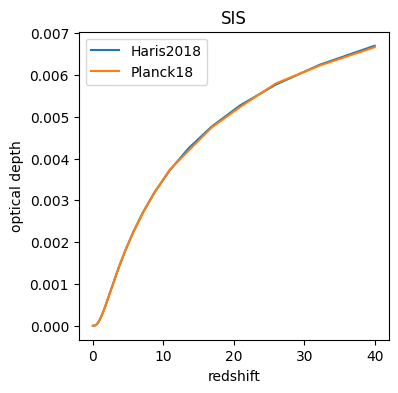

In [12]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='Haris2018')
plt.plot(zs, tau_sis2, label='Planck18')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.title('SIS')
plt.legend()
plt.show()

In [15]:
zs = np.geomspace(0.001, 2, 50)
# Haris
cosmo = cosmoLambdaCDM
tau_sis1 = strong_lensing_optical_depth_SIS(zs)
# planck18
cosmo = Planck18
tau_sis2 = np.array([optical_depth_SIS(zs=z) for z in zs])

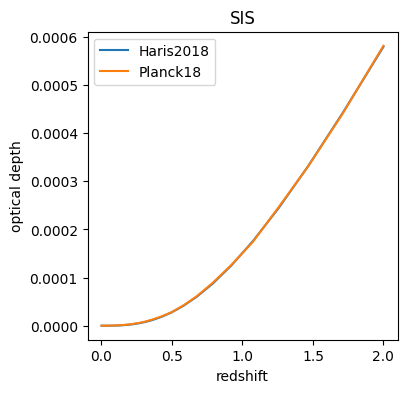

In [16]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='Haris2018')
plt.plot(zs, tau_sis2, label='Planck18')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.title('SIS')
plt.legend()
plt.show()

* changing cosmology doesn't change the optical depth much 

# SIE

* Without velocity dispersion dependence on lens redshift

In [174]:
a,b = sample_velocity_dispersion_axis_ratio(100)

In [175]:
b

array([0.70973286, 0.70890112, 0.38387781, 0.45006294, 0.67698366,
       0.95046194, 0.48034457, 0.69368817, 0.67218621, 0.66198473,
       1.        , 0.49632018, 0.84755202, 0.90242518, 0.80115544,
       0.87075252, 0.57066252, 0.85086241, 0.55202617, 0.60434327,
       0.75856813, 1.        , 0.70354043, 0.55761062, 0.9474162 ,
       0.49944522, 0.20500496, 0.6814376 , 0.45416646, 0.92501057,
       0.39810472, 0.67574921, 0.72931409, 0.51131431, 0.51641394,
       0.4749512 , 0.38670509, 0.31945441, 0.85525784, 0.32099854,
       0.55323532, 0.69965014, 0.833516  , 0.43977157, 0.86534201,
       0.33671928, 0.57514895, 0.45741801, 0.28611347, 0.90257609,
       0.21939532, 0.22052139, 0.67346928, 0.98281692, 0.96419569,
       0.54621053, 0.67296884, 0.87818232, 0.78100494, 0.77145828,
       0.56431365, 0.59534957, 0.58977581, 0.67951272, 0.6670778 ,
       0.59369853, 0.57273016, 0.46728311, 0.66169074, 0.79152595,
       0.92561104, 0.26022235, 0.53282813, 0.45871984, 0.72875

In [268]:
from numba import njit, jit

@jit
def sample_velocity_dispersion_axis_ratio(size):

    # Draw the velocity dispersion
    a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
    sigma = 161.0 * a
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q

@jit
def cross_section(sigma, zl, zs):
    Ds = cosmo.angular_diameter_distance(zs)
    Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / (Ds)
    )  # Note: km/s for sigma; Dls, Ds are in Mpc
    phi = np.pi * theta_E**2

    return phi

@njit
def phi_cut_SIE(q):
    n = len(q)
    result = np.empty(n)
    for i in range(n):
        val = q[i]
        if 0.01 < val < 0.99:
            result[i] = (2 * np.pi * val * np.log(val)) / (val ** 2 - 1)
        elif val < 0.01:
            result[i] = -2 * (np.pi * np.log(val)) * val
        else:
            result[i] = np.pi
    return result/np.pi

@jit
def integrand(zl, zs):
    sigma, q = sample_velocity_dispersion_axis_ratio(size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

@jit
def optical_depth_SIE(zs):
    result = quad(integrand, 0, zs, args=(zs))

    return result[0]

In [269]:
sigma, q = sample_velocity_dispersion_axis_ratio(size=200)

INFO:numba.core.transforms:finding looplift candidates


In [270]:
optical_depth_SIE(1.5)

INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates


0.0003386634209729854

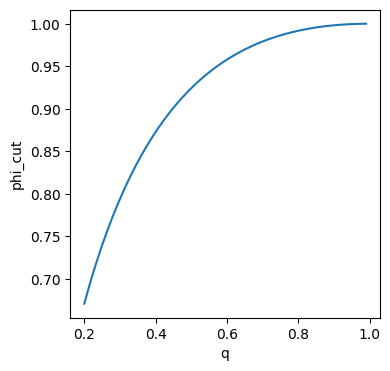

In [197]:
# plot phi_cut_SIE vs q
q = np.linspace(0.2, 0.99, 50)
phi_cut = phi_cut_SIE(q)

plt.figure(figsize=(4,4))
plt.plot(q, phi_cut)
plt.xlabel('q')
plt.ylabel('phi_cut')
plt.show()


In [200]:
zs = np.geomspace(0.001, 40, 50)
# Haris
cosmo = cosmoLambdaCDM
tau_sis1 = strong_lensing_optical_depth_SIS(zs)
# LambdaCDM
cosmo = cosmoLambdaCDM
tau_sie1 = np.array([optical_depth_SIE(zs=z) for z in zs])

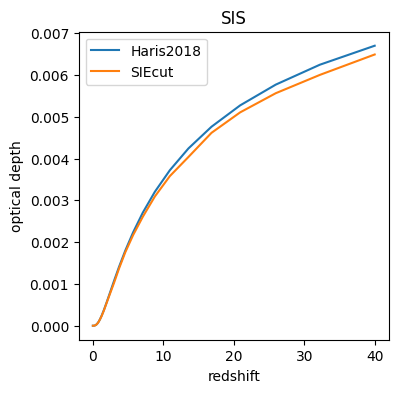

In [201]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='Haris2018')
plt.plot(zs, tau_sie1, label='SIEcut')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.title('SIS')
plt.legend()
plt.show()

In [198]:
zs = np.geomspace(0.001, 2, 50)
# Haris
tau_sis1 = strong_lensing_optical_depth_SIS(zs)
# planck18
tau_sie2 = np.array([optical_depth_SIE(zs=z) for z in zs])

INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates


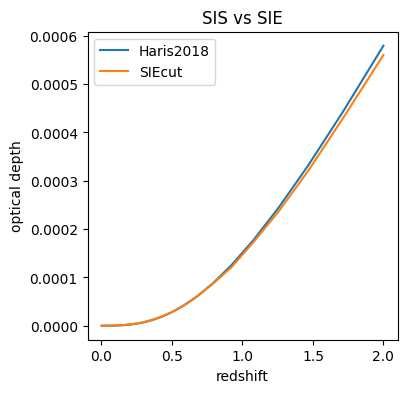

In [199]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='Haris2018')
plt.plot(zs, tau_sie2, label='SIEcut')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.title('SIS vs SIE')
plt.legend()
plt.show()

* At low lens redshifts, the optical depth is slightly lower than that of Haris et al. 2018, but it's not significant. 

# SIE

* With velocity dispersion dependence on lens redshift

In [224]:
import test
#reload(test)
import importlib
importlib.reload(test)

<module 'test' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test.py'>

In [250]:
from numba import njit, jit

@jit
def sample_velocity_dispersion_axis_ratio(zl, sigma_lim=[60,600], size=200):

    sigma = test.conditional_rejection_sample(test.phi,sigma_lim[0],sigma_lim[1],zl,size)
    q = np.zeros(size)
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q

@jit
def cross_section(sigma, zl, zs):
    Ds = cosmo.angular_diameter_distance(zs)
    Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / (Ds)
    )  # Note: km/s for sigma; Dls, Ds are in Mpc
    phi = np.pi * theta_E**2

    return phi

@njit
def phi_cut_SIE(q):
    n = len(q)
    result = np.empty(n)
    for i in range(n):
        val = q[i]
        if 0.01 < val < 0.99:
            result[i] = (2 * np.pi * val * np.log(val)) / (val ** 2 - 1)
        elif val < 0.01:
            result[i] = -2 * (np.pi * np.log(val)) * val
        else:
            result[i] = np.pi
    return result/np.pi

@jit
def integrand(zl, zs):
    sigma, q = sample_velocity_dispersion_axis_ratio(zl,size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

@jit
def optical_depth_SIE2(zs):
    result = quad(integrand, 0, zs, args=(zs))

    return result[0]

In [252]:
optical_depth_SIE2(1.5)

0.0009196458619426946

In [253]:
optical_depth_SIE(1.5)

0.0009243448474112417

In [262]:
#optical_depth_SIS(1.5)
strong_lensing_optical_depth_SIS(1.5)

0.0003465350907932671

In [257]:
zs = np.linspace(0.001, 2, 10)
# Haris
tau_sis1 = optical_depth_SIS(zs)
# planck18
tau_sie2 = np.array([optical_depth_SIE2(zs=z) for z in zs])

In [263]:
tau_sis1 = np.array([optical_depth_SIS(zs=z) for z in zs])

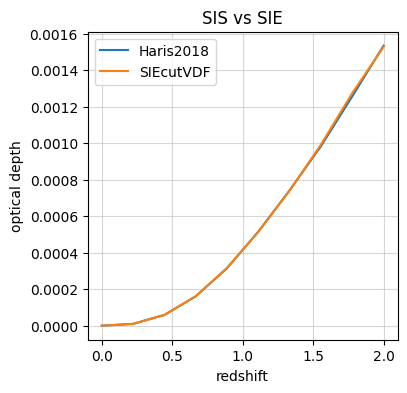

In [264]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='Haris2018')
plt.plot(zs, tau_sie2, label='SIEcutVDF')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.title('SIS vs SIE')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [248]:
zs = np.linspace(0.001, 2, 20)
# Haris
tau_sis1 = strong_lensing_optical_depth_SIS(zs)
# planck18
tau_sie3 = np.array([optical_depth_SIE2(z) for z in zs])

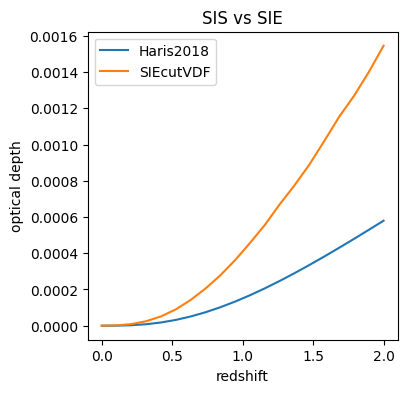

In [249]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis1, label='Haris2018')
plt.plot(zs, tau_sie3, label='SIEcutVDF')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.title('SIS vs SIE')
# plt.xlim(0,1)
# plt.ylim(0,0.2*1e-4)
plt.legend()
plt.show()

In [ ]:
### Reproduction of 

In [107]:
import test
#reload(test)
import importlib
importlib.reload(test)

<module 'test' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test.py'>

In [60]:
sigma = np.linspace(0, 500, 100)
z = np.ones(100)*1.5
#z0 = np.ones(100)*0.001
#phi0 = test.phitest(sigma,z0)
#phi1 = test.philoc(sigma)*test.pdf_phi_z_div_0(sigma, z)
#phi2 = test.philoc(sigma)*test.pdf_phi_z_div_0(sigma, z)*test.pdfz(z)
phi = test.phi(sigma,z)


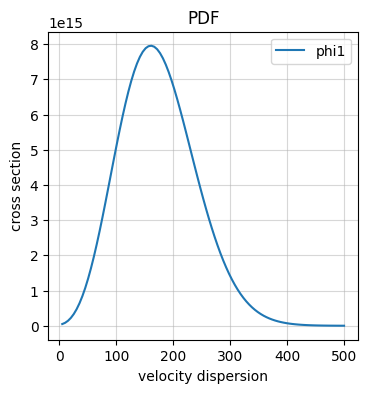

In [62]:
# plot 
plt.figure(figsize=(4,4))
plt.plot(sigma, sigma**4*phi, label='phi1')
#plt.plot(sigma, sigma**4*phi2, label='phi2')
plt.xlabel('velocity dispersion')
plt.ylabel('cross section')
plt.title('PDF')
#plt.yscale('log10')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [229]:
from scipy.interpolate import interp1d

def create_inv_cdf(x,y):
    
    # remove idx of nan values
    idx = np.argwhere(np.isnan(y))
    x = np.delete(x, idx)
    y = np.delete(y, idx)
    # create pdf with interpolation
    pdf_unorm = interp1d(x, y, kind='cubic', fill_value="extrapolate")
    xlim=[x[0], x[-1]]
    norm = quad(pdf_unorm, xlim[0], xlim[1])[0]
    y = y/norm
    pdf = interp1d(x, y, kind='cubic', fill_value="extrapolate")


    # create cdf
    # def cdf_fn():
    #     cdf = []
    #     for x_ in x:
    #         cdf.append(quad(pdf, xlim[0], x_)[0])
    #     return cdf
    cdf = lambda x: quad(pdf, xlim[0], x)[0]
    # get all values of cdf
    cdf_values = np.array([cdf(x_) for x_ in x])

    inv_cdf = interp1d(cdf_values, x, kind='cubic')

    return pdf, cdf, inv_cdf

In [230]:
sigma = np.linspace(0, 500, 20)
z = np.ones(20)*1.5556761439304723
phi = test.phi(sigma,z)

pdf, cdf, inv_cdf = create_inv_cdf(x=sigma,y=phi)

In [231]:
size = 10000
u = np.random.uniform(0, 1, size=size)
sigma_sampled = inv_cdf(u)

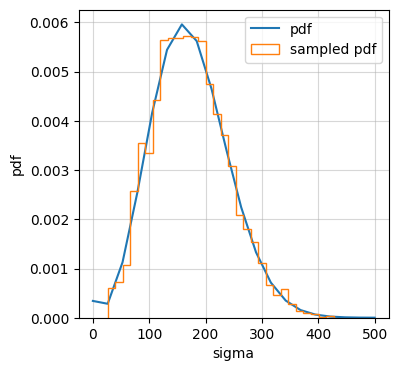

In [238]:
# plot cdf and pdf
plt.figure(figsize=(4,4))
plt.plot(sigma, pdf(sigma), label='pdf')
# cdf_values = np.array([cdf(x_) for x_ in sigma])
#plt.plot(sigma, cdf_values, label='cdf')
# plot hist
plt.hist(sigma_sampled, bins=30, density=True, histtype='step', label='sampled pdf')
plt.xlabel('sigma')
plt.ylabel('pdf')
plt.grid(alpha=0.5)
plt.legend()
plt.show() 

In [ ]:
param_dict_given={
    'z_min': 0.001,
    'z_max': 10,
    'cosmology': cosmo,
    }
folder="./interpolator_pickle"

path_inv_cdf, it_exist = self.interpolator_pickle_path(param_dict_given, folder)

if it_exist:
    print(
        f"Inveverse CDF of Velocity dispersion for inverse transform sampling will be loaded from {path_inv_cdf}"
    )
else:
    print(
        f"Inveverse CDF of Velocity dispersion for inverse transform sampling will be generated at {path_inv_cdf}"
    )
    init_inv_cdf_interpolation()


In [131]:
import test
#reload(test)
import importlib
importlib.reload(test)
from ler.utils import create_inv_cdf

In [235]:
import test2
#reload(test)
import importlib
importlib.reload(test2)

<module 'test2' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test2.py'>

In [236]:
vd = test2.VelocityDispersionSampler()

Inveverse CDF of Velocity dispersion for inverse transform sampling will be generated at ./interpolator_pickle/vel_disp/inv_cdf_0.pickle


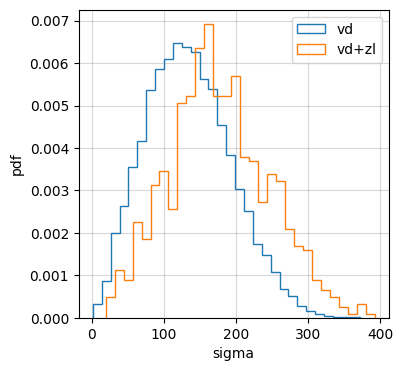

In [241]:
# plot velo disp
plt.figure(figsize=(4,4))
a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
sigma = 161.0 * a
plt.hist(sigma, bins=30, density=True, histtype='step', label='vd')
# plot hist
sample = vd.sample_vel_disp(1.5, 1000)
plt.hist(sample, bins=30, density=True, histtype='step', label='vd+zl')
plt.xlabel('sigma')
plt.ylabel('pdf')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

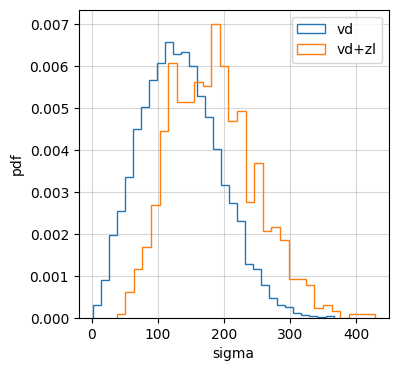

In [242]:
# plot velo disp
plt.figure(figsize=(4,4))
a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
sigma = 161.0 * a
plt.hist(sigma, bins=30, density=True, histtype='step', label='vd')
# plot hist
sample = vd.sample_vel_disp(0.2, 1000)
plt.hist(sample, bins=30, density=True, histtype='step', label='vd+zl')
plt.xlabel('sigma')
plt.ylabel('pdf')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [13]:
sig, q = sample_velocity_dispersion_axis_ratio(size=1000)

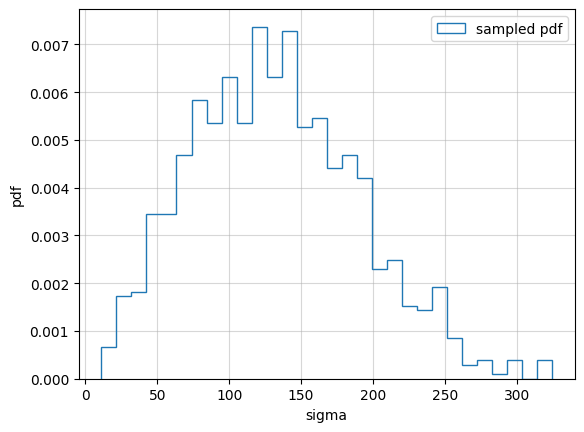

In [15]:
# plot hist
from scipy.stats import gengamma
a = gengamma.rvs(2.32 / 2.67, 2.67, size=1000)
sig = 161.0 * a
plt.hist(sig, bins=30, density=True, histtype='step', label='sampled pdf')
plt.xlabel('sigma')
plt.ylabel('pdf')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [43]:
# combining sigma and q in a function
nsamples_z = 100
nsamples_sigma = 100
z = np.ones(nsamples_sigma)
sigma = np.linspace(50, 400, nsamples_sigma)

num1 = test.pdf_phi_z_div_0(sigma, z*1.0)
num2 = test.pdf_phi_z_div_0(sigma, z*2.0)
num3 = test.pdf_phi_z_div_0(sigma, z*3.0)
num4 = test.pdf_phi_z_div_0(sigma, z*4.0)
num5 = test.pdf_phi_z_div_0(sigma, z*5.0)
num6 = test.pdf_phi_z_div_0(sigma, z*6.0)


In [41]:
num1 = test.philocbernardi(sigma)*test.pdf_phi_z_div_0(sigma, z*1.0)
num2 = test.philocbernardi(sigma)*test.pdf_phi_z_div_0(sigma, z*2.0)
num3 = test.philocbernardi(sigma)*test.pdf_phi_z_div_0(sigma, z*3.0)
num4 = test.philocbernardi(sigma)*test.pdf_phi_z_div_0(sigma, z*4.0)
num5 = test.philocbernardi(sigma)*test.pdf_phi_z_div_0(sigma, z*5.0)
num6 = test.philocbernardi(sigma)*test.pdf_phi_z_div_0(sigma, z*6.0)

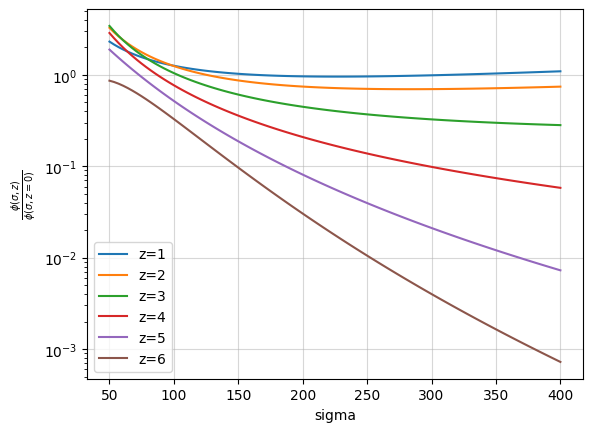

In [44]:
plt.plot(sigma, num1, label='z=1')
plt.plot(sigma, num2, label='z=2')
plt.plot(sigma, num3, label='z=3')
plt.plot(sigma, num4, label='z=4')
plt.plot(sigma, num5, label='z=5')
plt.plot(sigma, num6, label='z=6')
plt.xlabel('sigma')
plt.ylabel(r'$\frac{\phi(\sigma,z)}{\phi(\sigma,z=0)}$')
plt.yscale('log')
#plt.ylim(1e-1,1e1)
plt.grid(alpha=0.5)
plt.legend()
plt.show()